<a href="https://colab.research.google.com/github/M-torki/ECG-Classification/blob/main/MIT_BeatClassification_AF_VF_SV_NSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is for classification of extracted beats from PhysioNet MIT database. [This](https://physionet.org/about/database/) is a link to PhysioNet databases. 

Arrhythmia classes used in this study are:

AF: Atrial Fibrillation

VF: Ventricular Tachycardia

SV: Supraventricular Arrhythmia 

NSR: Normal


Extracted beat dataset which have .txt extension, created in "MIT data preparation" notebook and we just load them in this notebook.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd /gdrive/MyDrive/

/gdrive/MyDrive


In [ ]:
cd data_beat/MIT

/gdrive/.shortcut-targets-by-id/1OMdYP5uFn0bAwkC4m6f7Rl7qZjVv-N5Q/data_beat/MIT


In [ ]:
ls

afdb.txt  nsrdb.txt  svdb.txt  vfdb.txt


In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import shutil
from IPython.display import display 
import keras
from keras import optimizers, losses, activations, models
from keras.layers import Dense, BatchNormalization, Input, Activation, Dropout, Convolution1D, Conv1D, MaxPool1D , MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, MaxPool2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , Lambda, GaussianNoise
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam , Adadelta , Adagrad , SGD , RMSprop
from keras import regularizers
import keras.backend as K
from random import choice,shuffle
import glob

In [ ]:
af = np.loadtxt('./afdb.txt')
print(af.shape)

vf = np.loadtxt('./vfdb.txt')
print(vf.shape)

sv = np.loadtxt('./svdb.txt')
print(sv.shape)

nsr = np.loadtxt('./nsrdb.txt')
print(nsr.shape)

(3362, 200)
(1930, 200)
(25252, 200)
(76680, 200)


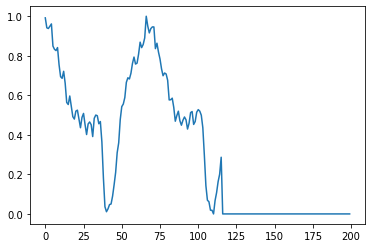

In [ ]:
plt.plot(vf[0,:])

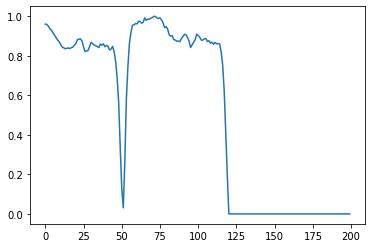

In [ ]:
plt.plot(af[1000,:])

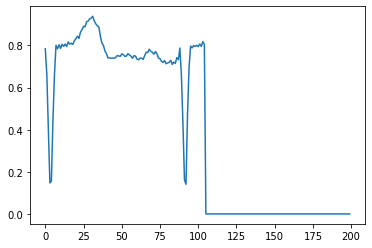

In [ ]:
plt.plot(nsr[1000,:])

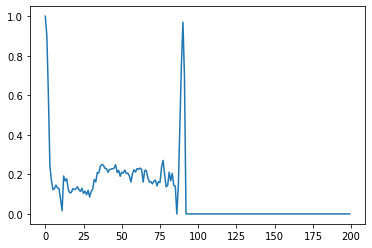

In [ ]:
plt.plot(sv[0,:])

In [ ]:
x_test = np.concatenate((af[:len(af)//5] , vf[:len(vf)//5] , sv[:len(sv)//5] , nsr[:len(nsr)//5]) , axis=0)
x_test.shape

(21444, 200)

In [ ]:
x_train = np.concatenate((af[len(af)//5:] , vf[len(vf)//5:] ,  sv[len(sv)//5:] , nsr[len(nsr)//5:]) , axis=0)
x_train.shape

(85780, 200)

In [ ]:
y_test = []
for i in range(len(af)//5):
    y_test.append([1,0,0,0])
for i in range(len(vf)//5):
    y_test.append([0,1,0,0])
for i in range(len(sv)//5):
    y_test.append([0,0,1,0])
for i in range(len(nsr)//5):
    y_test.append([0,0,0,1])
y_test = np.array(y_test)
y_test.shape

(21444, 4)

In [ ]:
y_train = []
for i in range(len(af)//5 , len(af)):
    y_train.append([1,0,0,0])
for i in range(len(vf)//5 , len(vf)):
    y_train.append([0,1,0,0])
for i in range(len(sv)//5 , len(sv)):
    y_train.append([0,0,1,0])
for i in range(len(nsr)//5 , len(nsr)):
    y_train.append([0,0,0,1])
y_train = np.array(y_train)
y_train.shape

(85780, 4)

In [ ]:
x_test = np.expand_dims(x_test , -1)
x_train = np.expand_dims(x_train , -1)

print(x_test.shape , x_train.shape)

(21444, 200, 1) (85780, 200, 1)


In [ ]:
from sklearn.utils import shuffle
x_train , y_train = shuffle(x_train,y_train , random_state=42)
x_test , y_test = shuffle(x_test,y_test , random_state=42)

In [ ]:
for i in range(len(x_train)):
    z = x_train[i,:]
    z = (z-np.mean(z))/(np.std(z)+1e-30)
    x_train[i,:] = z

for i in range(len(x_test)):
    z = x_test[i,:]
    z = (z-np.mean(z))/(np.std(z)+1e-30)
    x_test[i,:] = z

print(x_test[0].std() , x_train[0].std())

1.0 1.0


In [ ]:
m = Sequential()
m.add(GaussianNoise(0.1))
m.add(Conv1D(16,
                input_shape=[200, 1],
                kernel_size=80,
                strides=2,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Conv1D(32,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Conv1D(64,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Conv1D(96,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Conv1D(96*2,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
# m.add(Flatten())
# m.add(Dropout(0.5))
# m.add(Dense(16, activation='relu'))

m.add(Dropout(0.5))
m.add(Dense(4, activation='softmax'))

In [ ]:
m.build(input_shape=(None, 200, 1))

In [ ]:
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 200, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 16)           1296      
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 16)           64        
_________________________________________________________________
activation_5 (Activation)    (None, 100, 16)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 50, 16)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 50, 32)            1568      
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 32)           

In [ ]:
m.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
batch_size = 64

m.fit(x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=5,
        verbose=1,
        validation_split = 0.1,
)

Epoch 1/5
1207/1207 [==============================] - 48s 38ms/step - loss: 0.0245 - accuracy: 0.9975 - val_loss: 0.0298 - val_accuracy: 0.9963
Epoch 2/5
1207/1207 [==============================] - 47s 39ms/step - loss: 0.0215 - accuracy: 0.9982 - val_loss: 0.0309 - val_accuracy: 0.9962
Epoch 3/5
1207/1207 [==============================] - 46s 38ms/step - loss: 0.0203 - accuracy: 0.9986 - val_loss: 0.0305 - val_accuracy: 0.9959
Epoch 4/5
1207/1207 [==============================] - 46s 38ms/step - loss: 0.0192 - accuracy: 0.9987 - val_loss: 0.0300 - val_accuracy: 0.9963
Epoch 5/5
1207/1207 [==============================] - 46s 38ms/step - loss: 0.0175 - accuracy: 0.9991 - val_loss: 0.0293 - val_accuracy: 0.9960


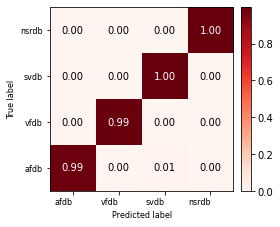

In [ ]:
pred = m.predict(x_train)
pr = [np.argmax(pred[i]) for i in range(len(y_train))]
Y = [np.argmax(y_train[i]) for i in range(len(y_train))]

conf_plotter(Y , pr , ['afdb' , 'vfdb', 'svdb' , 'nsrdb' ] , normalize=1, cmap = plt.cm.Reds ,mode='train', save=0 , name='RawData_Deep_physionet.png')

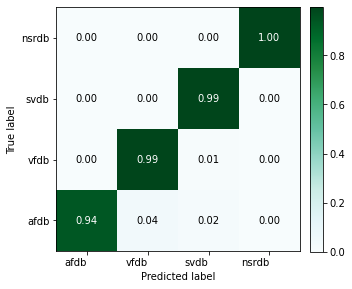

In [ ]:
# pred = m.predict(x_test)
# pr = [np.argmax(pred[i]) for i in range(len(y_test))]
# Y = [np.argmax(y_test[i]) for i in range(len(y_test))]

conf_plotter(Y , pr , ['afdb' , 'vfdb' , 'svdb' , 'nsrdb'] , normalize=1, cmap = plt.cm.BuGn ,mode='test', save=1 , name='MIT_AF.VF.SV.NSR.png')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y ,pr , target_names=['afdb' , 'vfdb' , 'svdb' , 'nsrdb'] ))

              precision    recall  f1-score   support

        afdb       0.97      0.94      0.96       672
        vfdb       0.90      0.99      0.94       386
        svdb       1.00      0.99      0.99      5050
       nsrdb       1.00      1.00      1.00     15336

    accuracy                           1.00     21444
   macro avg       0.97      0.98      0.97     21444
weighted avg       1.00      1.00      1.00     21444



In [ ]:
# serialize model to JSON
model_json = m.to_json()
with open("model_mit4cls.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m.save_weights("model_mit4cls.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

In [ ]:
def conf_plotter(y_true, y_pred, classes,
                normalize=0,
                title=None,
                cmap=plt.cm.pink_r,
                mode = 'train',
                save = 0,
                name = 'conf.jpg'):
  # if not title:
  #     if mode == 'train':
  #         title = 'Normalized confusion matrix on train dataset'
  #     if mode == 'test':
  #         title = 'Normalized confusion matrix on test dataset'
  #     if mode == 'prob':
  #         title = 'Normalized confusion matrix on Non-Overlapping test dataset'
          

  from sklearn.metrics import confusion_matrix
  
  cm = confusion_matrix(y_true, y_pred)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  fig, ax = plt.subplots(figsize=(5,5))
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax ,fraction=0.046, pad=0.04)
  ax.set(xticks=np.arange(cm.shape[0]),
        yticks=np.arange(cm.shape[1]),
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel= 'True label',
        xlabel='Predicted label')
  
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ):
                  
      item.set_fontsize(10)
  
  for item in (ax.get_xticklabels() + ax.get_yticklabels()):
      
      item.set_fontsize(10)

      
              
  plt.gca().invert_yaxis()
  plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
          rotation_mode="anchor")

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  if save == 1:
      plt.savefig(name)
  return ax